In [57]:
import os
import numpy as np
import pandas as pd
from bokeh.palettes import Category10
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
import cv2
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt



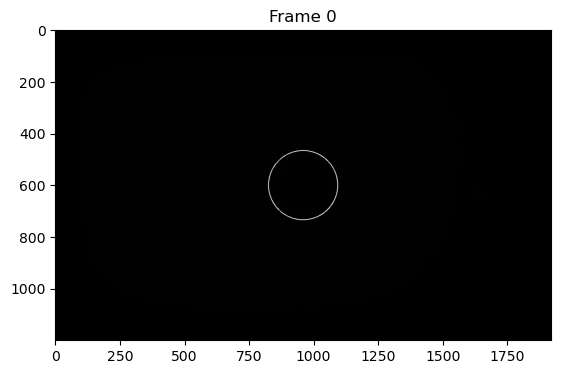

KeyError: 'frame'

In [68]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import trackpy as tp

def find_closest(df, col_name):
    value = (df[col_name].max() - df[col_name].min()) / 2
    dist = (df[col_name] - value).abs()
    return dist.idxmin()

# Define the master path
master_path = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local to global pre-print/FRAP/05-22-2023_MTdiffusion_photobleach_1uL_6.1_57min_1/Pos0/'

# Define the width and height of the ROI
roi_width, roi_height = 269, 269

# Get a sorted list of all .tif files in the directory
image_files = sorted(glob.glob(os.path.join(master_path, '*.tif')))

# Filter the list to only include files that contain "DLP_Red_000_" in their name
image_files = [f for f in image_files if 'DLP_Red_000' in f]

# Create a DataFrame to store the mean intensity of each frame
mean_intensities_df = pd.DataFrame(columns=['Frame Number', 'Mean Intensity'])

# Initialize a counter for the frames
frame_counter = 0

# Initialize the ROI position with None
roi_position = None

# Process the image files
for file in image_files:
    # Read the image
    img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

    # If this is the first frame or the ROI position is None, initialize the ROI position
    if roi_position is None:
        roi_position = (img.shape[1] // 2, img.shape[0] // 2)

    # Compute the boundaries of the ROI
    roi_x_min = int(max(0, roi_position[0] - roi_width // 2))
    roi_x_max = int(min(img.shape[1], roi_position[0] + roi_width // 2))
    roi_y_min = int(max(0, roi_position[1] - roi_height // 2))
    roi_y_max = int(min(img.shape[0], roi_position[1] + roi_height // 2))

    # Extract the ROI
    roi = img[roi_y_min:roi_y_max, roi_x_min:roi_x_max]

    # Compute the mean intensity
    mean_intensity = np.mean(roi)
    
    # Save the mean intensity and the frame number to the DataFrame
    mean_intensities_df.loc[frame_counter] = [frame_counter, mean_intensity]

    # If the current frame is a multiple of 10, draw the ROI and display the image
    if frame_counter % 10 == 0:
        # Draw the ROI as a circle on the image
        cv2.circle(img, roi_position, roi_width // 2, (255), 2)

        # Display the image using matplotlib
        plt.imshow(img, cmap='gray')
        plt.title(f'Frame {frame_counter}')
        plt.show()

    # Track the new ROI position
    if frame_counter < len(image_files) - 1:
        # Compute the features in the current and next frame
        current_frame = tp.locate(img, roi_width)
        next_img = cv2.imread(image_files[frame_counter + 1], cv2.IMREAD_GRAYSCALE)
        next_frame = tp.locate(next_img, roi_width)

        # Match the features between the current and next frame
        matched_features = tp.link_df(f=pd.concat([current_frame, next_frame]), search_range=roi_width)

        # Update the ROI position
        roi_position = (matched_features.iloc[-1].x, matched_features.iloc[-1].y)

    frame_counter += 1

# Convert the 'Mean Intensity' column to numeric data type
mean_intensities_df['Mean Intensity'] = pd.to_numeric(mean_intensities_df['Mean Intensity'], errors='coerce')

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(mean_intensities_df['Mean Intensity'], 'o-')
plt.title('Mean Intensity over Time')
plt.xlabel('Frame Number')
plt.ylabel('Mean Intensity')
plt.grid()
plt.show()

# Use the function to find the closest frame
closest_frame = find_closest(mean_intensities_df, 'Mean Intensity')

print(f"The frame closest to the halfway point of max and min intensity is: {closest_frame}")


In [55]:

if not image_files:
    print("No files found matching the specified name pattern.")
else:
    # Read the first two images and define the ROI
    img1 = cv2.imread(image_files[0], 0)
    img2 = cv2.imread(image_files[1], 0)

    roi_center1 = (img1.shape[1]//2, img1.shape[0]//2)  # assumes ROI is in center
    roi_center2 = (img2.shape[1]//2, img2.shape[0]//2)  # assumes ROI is in center

    # Calculate the drift rate
    drift_rate = ((roi_center2[0] - roi_center1[0]), (roi_center2[1] - roi_center1[1]))

    # Create a DataFrame to store the mean intensities
    mean_intensities_df = pd.DataFrame(columns=['Image', 'Mean Intensity'])

    # Loop through the rest of the images
    for image_file in image_files[2:]:
        img = cv2.imread(image_file, 0)

        # Update the ROI center based on the drift rate
        roi_center = (roi_center2[0] + drift_rate[0], roi_center2[1] + drift_rate[1])

        # Extract the new ROI
        roi = img[int(roi_center[1]-roi_height//2):int(roi_center[1]+roi_height//2), int(roi_center[0]-roi_width//2):int(roi_center[0]+roi_width//2)]

        # Compute the mean intensity of the ROI
        mean_intensity = np.mean(roi)

        # Append the mean intensity to the DataFrame
        mean_intensities_df = mean_intensities_df.append({'Image': os.path.basename(image_file), 'Mean Intensity': mean_intensity}, ignore_index=True)

    # Print the DataFrame
    print(mean_intensities_df)


/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_31789/3275542401.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_intensities_df = mean_intensities_df.append({'Image': os.path.basename(image_file), 'Mean Intensity': mean_intensity}, ignore_index=True)
/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_31789/3275542401.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_intensities_df = mean_intensities_df.append({'Image': os.path.basename(image_file), 'Mean Intensity': mean_intensity}, ignore_index=True)
/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_31789/3275542401.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_intensities_df = mean_intensities_df.append({'Image': o

                             Image  Mean Intensity
0    img_000000002_DLP_Red_000.tif        7.951413
1    img_000000003_DLP_Red_000.tif        7.975885
2    img_000000004_DLP_Red_000.tif        7.984897
3    img_000000005_DLP_Red_000.tif        7.987421
4    img_000000006_DLP_Red_000.tif        7.994102
..                             ...             ...
159  img_000000161_DLP_Red_000.tif        8.000055
160  img_000000162_DLP_Red_000.tif        8.000055
161  img_000000163_DLP_Red_000.tif        8.000055
162  img_000000164_DLP_Red_000.tif        8.000082
163  img_000000165_DLP_Red_000.tif        8.000055

[164 rows x 2 columns]


/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_31789/3275542401.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_intensities_df = mean_intensities_df.append({'Image': os.path.basename(image_file), 'Mean Intensity': mean_intensity}, ignore_index=True)
/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_31789/3275542401.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_intensities_df = mean_intensities_df.append({'Image': os.path.basename(image_file), 'Mean Intensity': mean_intensity}, ignore_index=True)
/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_31789/3275542401.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_intensities_df = mean_intensities_df.append({'Image': o

In [4]:
def find_closest(df, col_name):
  value = (df[col_name].max() - df[col_name].min()) / 2
  dist = (df[col_name] - value).abs()
  return dist.idxmin()

In [2]:
# Specify the folder path
folder_path = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local to global pre-print/FRAP/data'

# Initialize an empty DataFrame
df = pd.DataFrame()

# Iterate over files in folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.xls') or file_name.endswith('.xlsx'):  # check if it's an Excel file
        file_path = os.path.join(folder_path, file_name)  # get the full path of the file
        temp_df = pd.read_excel(file_path, usecols = [0])  # read only first column of the file into a DataFrame
        temp_df.columns = [file_name]  # name the column with the file name (experimental condition)
        df = pd.concat([df, temp_df], axis=1)  # append the column to our main DataFrame

# Normalize the DataFrame
normalized_df = (df - df.min()) / (df.max() - df.min())

# Prepare the Bokeh plot
output_notebook()
p2 = figure(plot_width=600, plot_height=300, 
            title="Fluorescence recovery after photobleaching", 
            x_axis_label='frames', 
            y_axis_label='normalized intensity')

# Add lines to the plot for each experiment
for i, col in enumerate(normalized_df.columns):
    x = normalized_df.index
    y = normalized_df[col].dropna()
    p2.line(x=x, y=y, legend_label=col, color=Category10[10][i % 10])

# Show the plot
show(p2)

Loading BokehJS ...

In [7]:
def find_closest(df, col_name):
    value = (df[col_name].max() - df[col_name].min()) / 2
    dist = (df[col_name] - value).abs()
    return dist.idxmin()

# Calculate the tau half for mid point
tau_half = []
for col in normalized_df.columns:
    tau_half.append(find_closest(normalized_df, col) * 30)

tau_half


[1140, 240, 720, 390]

In [20]:
res = 0.294
D = []

for col, num in zip(normalized_df.columns, tau_half):
    if col.startswith('low_'):
        r_circle = 390
    else:
        r_circle = 135
    
    w = res * r_circle
    D.append(0.88 * w ** 2 / (4 * num))

D


[2.5371240631578944, 1.4440214249999999, 0.481340475, 7.4162088]

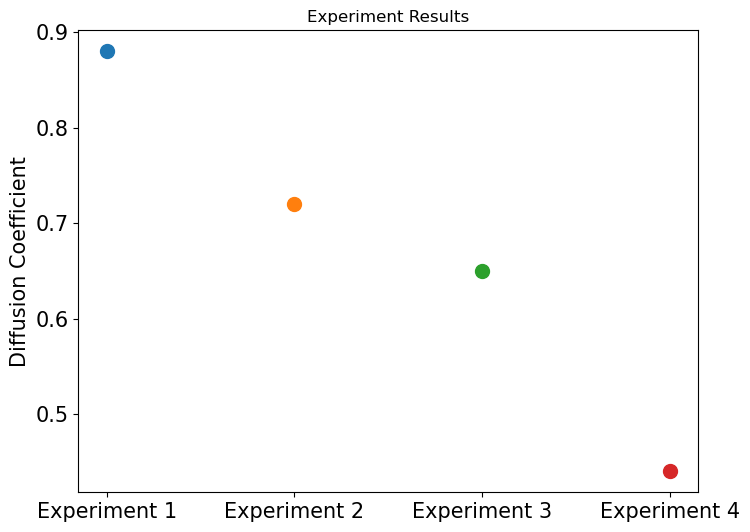

In [75]:
import matplotlib.pyplot as plt
from bokeh.palettes import Category10

# Specify the experiment names and corresponding values
experiments = ['Experiment 1', 'Experiment 2', 'Experiment 3', 'Experiment 4']
values = [0.88, 0.72, 0.65, 0.44]

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 15


# Create a scatter plot with each point in a different color
plt.figure(figsize=(8, 6))
for i in range(len(experiments)):
    plt.plot(experiments[i], values[i], 'o', color=Category10[10][i], markersize=10)

# Add a title and labels to the axes
plt.title('Experiment Results')
plt.ylabel('Diffusion Coefficient')

# Show the plot
plt.show()


In [21]:
for col, diffusion_coeff in zip(normalized_df.columns, D):
    print(f"File: {col}, Diffusion Coefficient: {diffusion_coeff}")


File: low_pH_360_min.xlsx, Diffusion Coefficient: 2.5371240631578944
File: 1_6.1_5min.xlsx, Diffusion Coefficient: 1.4440214249999999
File: 6.8_2hr.xlsx, Diffusion Coefficient: 0.481340475
File: low_pH_140min.xlsx, Diffusion Coefficient: 7.4162088


In [22]:
from scipy.optimize import fsolve
import numpy as np

# define given constants
k_B = 1.38e-23 * 1e12  # Boltzmann constant in um^2kg/s^2K
T = 25 + 273.15  # Temperature in Kelvin
eta = 2e3  # Viscosity in Pa.s (in um, kg, s scale)
r = 25e-3  # Radius in micrometers

# Create a function that represents our equation
def equation(L, D):
    return (2 * np.pi * eta * L * D) / (k_B * T) - np.log(L / (2 * r)) + 0.2

# Assuming you have 'D' as a list of diffusion coefficients from your previous code
lengths = []
for D in D:
    initial_guess = 1  # initial guess for the length L in micrometers
    L_solution, = fsolve(equation, initial_guess, args=(D,))
    lengths.append(L_solution)

# 'lengths' now contains the length for each diffusion coefficient in 'D_values', in micrometers


/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_31789/1934296743.py:12: RuntimeWarning: invalid value encountered in log
  return (2 * np.pi * eta * L * D) / (k_B * T) - np.log(L / (2 * r)) + 0.2
/opt/anaconda3/envs/active_matters/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [23]:
lengths

[1.0, 5.578647543913462e-10, 4.2740599948132285e-09, 1.0]

In [69]:
from scipy.optimize import fsolve
import numpy as np

k_B = 1.38e-11  # Boltzmann constant in um^2kg/s^2K
T = 25 + 273.15  # Temperature in Kelvin
eta = 2e13  # Viscosity in Pa.s (in um, kg, s scale)
r = 12.5e-3  # Radius in micrometers

# Create a function that represents our equation
def equation(L, D):
    return (2 * np.pi * eta * L * D) / (k_B * T) - np.log(L / (2 * r)) + 0.2

# Assuming you have 'D' as a list of diffusion coefficients from your previous code
D = 0.3
initial_guess = 1  # initial guess for the length L in micrometers
L_solution, = fsolve(equation, initial_guess, args=(D,))
L_solution
# 'lengths' now contains the length for each diffusion coefficient in 'D_values', in micrometers


/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_31789/1433687862.py:11: RuntimeWarning: invalid value encountered in log
  return (2 * np.pi * eta * L * D) / (k_B * T) - np.log(L / (2 * r)) + 0.2
/opt/anaconda3/envs/active_matters/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


1.0

In [18]:
lengths

[8.563307882116414e-18]